In [1]:
import os
import warnings

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scienceplots
plt.style.reload_library()
plt.style.use("science")
from matplotlib import ticker
import tol_colors as tc
cset =  tc.tol_cset("medium-contrast")

In [2]:
def plot(problem, size, new=False):
    penalties = [0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]
    # load data
    results = loadRes(problem, size, penalties, new)
    # init fig
    fig, axes = plt.subplots(2, 1, figsize=(8, 8))
    # feasibility rate
    drawFeas(axes, results, problem, size, penalties)
    # objective value
    drawObj(axes, results, problem, size, penalties=[0.1, 1, 10, 100, 1000])
    # plot
    fig.tight_layout()
    plt.savefig(f"./img/{problem}_s{size}_penalty.pdf", dpi=300, bbox_inches="tight")

def drawFeas(axes, results, problem, size, penalties):
    # line
    rc_frate = [(results["RC"][p]["Num Violations"]>0).mean()*100 for p in penalties]
    lt_frate = [(results["LT"][p]["Num Violations"]>0).mean()*100 for p in penalties]
    rcp_frate = [(results["RC-P"][p]["Num Violations"]>0).mean()*100 for p in penalties]
    ltp_frate = [(results["LT-P"][p]["Num Violations"]>0).mean()*100 for p in penalties]
    axes[0].plot(100-np.array(rc_frate), marker="o", linestyle="-", linewidth=3, markersize=10, label="RC", color=cset.light_blue)
    axes[0].plot(100-np.array(lt_frate), marker="o", linestyle="-", linewidth=3, markersize=10, label="LT", color=cset.light_red)
    line1, = axes[0].plot(100-np.array(rcp_frate), marker="D", linestyle="--", linewidth=3, markersize=8, label="RC-P", color=cset.dark_blue)
    line2, = axes[0].plot(100-np.array(ltp_frate), marker="D", linestyle="--", linewidth=3, markersize=8, label="LT-P", color=cset.dark_red)
    # offset
    line2.set_dashes((3, 3, 0))
    line2.set_dashes((3, 3, 3))
    # annotate
    #for i, val in enumerate(rc_frate):
    #    plt.text(i+0.2, val+3, f"{val:.0f}\%", ha="center", fontsize=20, color=cset.mint)
    #for i, val in enumerate(lt_frate):
    #    plt.text(i-0.2, val-5, f"{val:.0f}\%", ha="center", fontsize=20, color=cset.pink)
    # style
    if problem == "cq":
        axes[0].set_title(f"{size}×{size} Integer Quadratic", fontsize=36)
    if problem == "nc":
        axes[0].set_title(f"{size}×{size} Integer Non-Convex", fontsize=36)
    if problem == "rb":
        axes[0].set_title(f"{size*2}×4 Mixed-Integer Rosenbrock", fontsize=36)
    # grid
    axes[0].grid(color="grey", alpha=0.5, linewidth=0.5, which="major", axis="y")
    # style
    #axes[0].set_xlabel("Penalty Weights", fontsize=36)
    axes[0].set_ylabel("\% Feasibility", fontsize=36)
    axes[0].set_xticks(ticks=range(len(penalties)), labels=penalties, fontsize=30)
    axes[0].set_yticks(np.arange(0, 101, 20))
    axes[0].set_xticks(ticks=range(0, len(penalties), 2)) 
    axes[0].tick_params(axis="y", labelsize=30)
    axes[0].set_xlim(-0.3, len(penalties)-0.7)
    axes[0].set_ylim(-3, 103)
    axes[0].legend(title="Method", fontsize=24, title_fontsize=24, ncol=2, columnspacing=0.5, handlelength=1.0, handleheight=0.5)

def drawObj(axes, results, problem, size, penalties):
    rc_obj = pd.DataFrame({p:results["RC"][p]["Obj Val"].values for p in penalties})
    lt_obj = pd.DataFrame({p:results["LT"][p]["Obj Val"].values for p in penalties})
    rcp_obj = pd.DataFrame({p:results["RC-P"][p]["Obj Val"].values for p in penalties})
    ltp_obj = pd.DataFrame({p:results["LT-P"][p]["Obj Val"].values for p in penalties})
    c = cset.light_blue
    bp1 = axes[1].boxplot(rc_obj, boxprops=dict(facecolor=c, color=c, linewidth=4), medianprops=dict(color="w", linewidth=1), 
                  whiskerprops=dict(color=c, linewidth=2), capprops=dict(color=c, linewidth=2),
                  flierprops=dict(markeredgecolor=c, marker="o", markersize=4, markeredgewidth=2),
                  patch_artist=True, positions=np.arange(len(penalties))-0.36, widths=0.16)
    c = cset.light_red
    bp2 = axes[1].boxplot(lt_obj, boxprops=dict(facecolor=c, color=c, linewidth=4), medianprops=dict(color="w", linewidth=1), 
                      whiskerprops=dict(color=c, linewidth=2), capprops=dict(color=c, linewidth=2),
                      flierprops=dict(markeredgecolor=c, marker="o", markersize=4, markeredgewidth=2),
                      patch_artist=True, positions=np.arange(len(penalties))+0.12, widths=0.16)
    c = cset.dark_blue
    bp3 = axes[1].boxplot(rcp_obj, boxprops=dict(facecolor=c, color=c, linewidth=4), medianprops=dict(color="w", linewidth=1), 
                  whiskerprops=dict(color=c, linewidth=2), capprops=dict(color=c, linewidth=2),
                  flierprops=dict(markeredgecolor=c, marker="o", markersize=4, markeredgewidth=2),
                  patch_artist=True, positions=np.arange(len(penalties))-0.12, widths=0.16)
    c = cset.dark_red
    bp4 = axes[1].boxplot(ltp_obj, boxprops=dict(facecolor=c, color=c, linewidth=4), medianprops=dict(color="w", linewidth=1), 
                      whiskerprops=dict(color=c, linewidth=2), capprops=dict(color=c, linewidth=2),
                      flierprops=dict(markeredgecolor=c, marker="o", markersize=4, markeredgewidth=2),
                      patch_artist=True, positions=np.arange(len(penalties))+0.36, widths=0.16)
    # vertical line
    for i in range(len(penalties)):
       plt.axvline(x=i+0.5, color="k", linestyle="--", linewidth=1, alpha=0.75)
    # grid
    axes[1].grid(color="grey", alpha=0.5, linewidth=0.5, which="major", axis="y")
    axes[1].set_xlabel("Penalty Weights", fontsize=36)
    axes[1].set_ylabel("Objective Value", fontsize=36)
    axes[1].set_xticks(ticks=range(len(penalties)), labels=penalties, fontsize=30)
    axes[1].tick_params(axis="y", labelsize=30)
    if problem == "rb":
        axes[1].set_yscale("log")
        axes[1].text(0.32, 1e4, "Value is too large.", ha="center", va="bottom", fontsize=18, color=cset.dark_red, rotation=90, fontweight="bold")
        axes[1].text(1.32, 1e4, "Value is too large.", ha="center", va="bottom", fontsize=18, color=cset.dark_red, rotation=90, fontweight="bold")
    axes[1].set_xlim(-0.5, len(penalties)-0.5)
    # adjust scientific notation font size
    offset_text = axes[1].yaxis.get_offset_text()  # Get scientific notation text
    offset_text.set_fontsize(24)
    axes[1].legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0], bp4["boxes"][0]], ["RC", "LT", "RC-P", "LT-P"], title="Method", 
               fontsize=24, title_fontsize=24, ncol=2, columnspacing=0.5, handlelength=0.5, handleheight=0.5)

def loadRes(problem, size, penalties, new):
    # init a list to store processed results
    results = {"RC":{},"LT":{}, "RC-P":{},"LT-P":{}}
    # loop through each size
    for p in penalties:
        # retrive metrics
        df = retriveData(problem, size, "cls", p, new)
        results["RC"][p] = df
    # loop through each size
    for p in penalties:
        # retrive metrics
        df = retriveData(problem, size, "thd", p, new)
        results["LT"][p] = df
    # loop through each size
    for p in penalties:
        # retrive metrics
        df = retriveData(problem, size, "cls", p, new, True)
        results["RC-P"][p] = df
    # loop through each size
    for p in penalties:
        # retrive metrics
        df = retriveData(problem, size, "thd", p, new, True)
        results["LT-P"][p] = df
    return results

def retriveData(problem, size, method, penalty_weight, new, proj=False):
    # dir and file
    data_path = "./result/"
    if problem == "rb":
        if new:
            if proj:
                csv_file = os.path.join(data_path, f"{problem}_{method}{penalty_weight}_{size}-p_new.csv")
            else:
                csv_file = os.path.join(data_path, f"{problem}_{method}{penalty_weight}_{size}_new.csv")
        else:
            if proj:
                csv_file = os.path.join(data_path, f"{problem}_{method}{penalty_weight}_{size}-p.csv")
            else:
                csv_file = os.path.join(data_path, f"{problem}_{method}{penalty_weight}_{size}.csv")
    else:
        if new:
            if proj:
                csv_file = os.path.join(data_path, f"{problem}_{method}{penalty_weight}_{size}-{size}-p_new.csv")
            else:
                csv_file = os.path.join(data_path, f"{problem}_{method}{penalty_weight}_{size}-{size}_new.csv")
        else:
            if penalty_weight == 100:
                if proj:
                    try:
                        csv_file = os.path.join(data_path, f"{problem}_{method}_{size}-{size}-p.csv")
                        df = pd.read_csv(csv_file)
                    except:
                        csv_file = os.path.join(data_path, f"{problem}_{method}{penalty_weight}_{size}-{size}-p.csv")
                else:
                    try:
                        csv_file = os.path.join(data_path, f"{problem}_{method}_{size}-{size}.csv")
                        df = pd.read_csv(csv_file)
                    except:
                        csv_file = os.path.join(data_path, f"{problem}_{method}{penalty_weight}_{size}-{size}.csv")
            else:
                if proj:
                    csv_file = os.path.join(data_path, f"{problem}_{method}{penalty_weight}_{size}-{size}-p.csv")
                else:
                    csv_file = os.path.join(data_path, f"{problem}_{method}{penalty_weight}_{size}-{size}.csv")
    # load data
    df = pd.read_csv(csv_file)
    # filter df
    if "Num Violations" in df.columns:
        return df[["Obj Val", "Num Violations"]]
    else:
        return df[["Obj Val", "Constraints Viol"]]

### Convex Quadratic

### 1000x1000

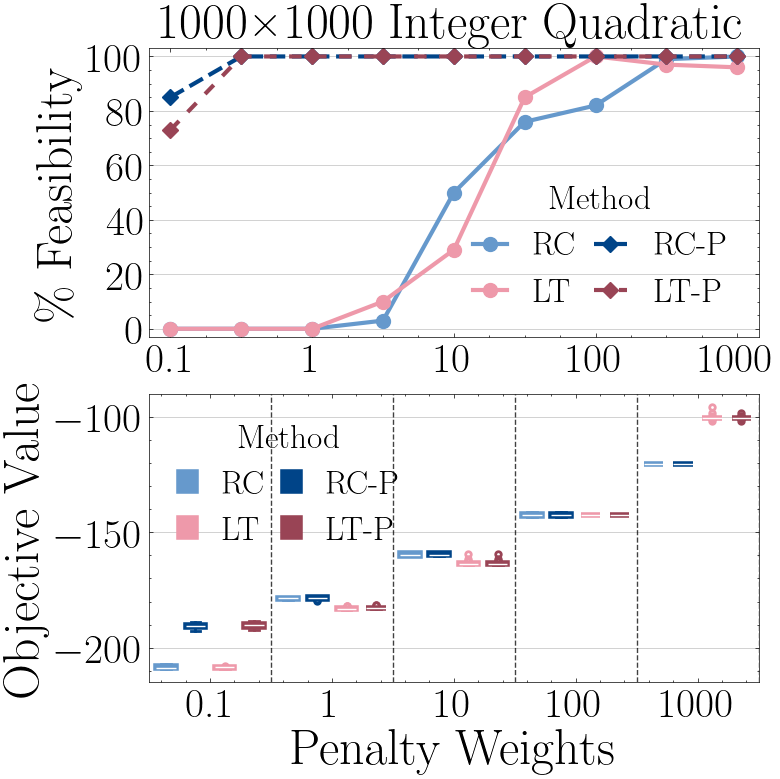

In [3]:
plot(problem="cq", size=1000)

### Simple Non-Convex

#### 1000x1000

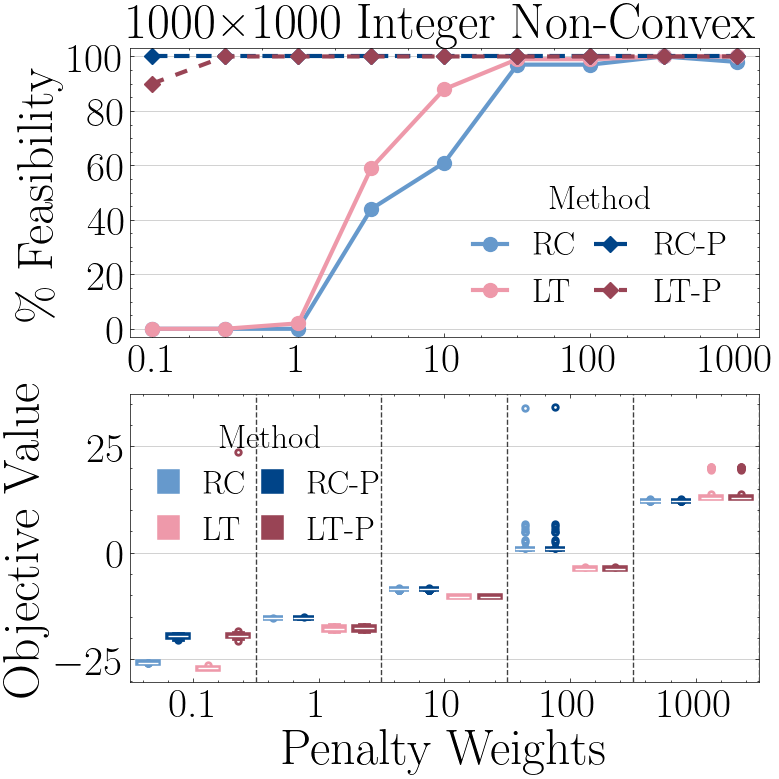

In [4]:
plot(problem="nc", size=1000, new=True)

### Rosenbrock

#### 1000x4

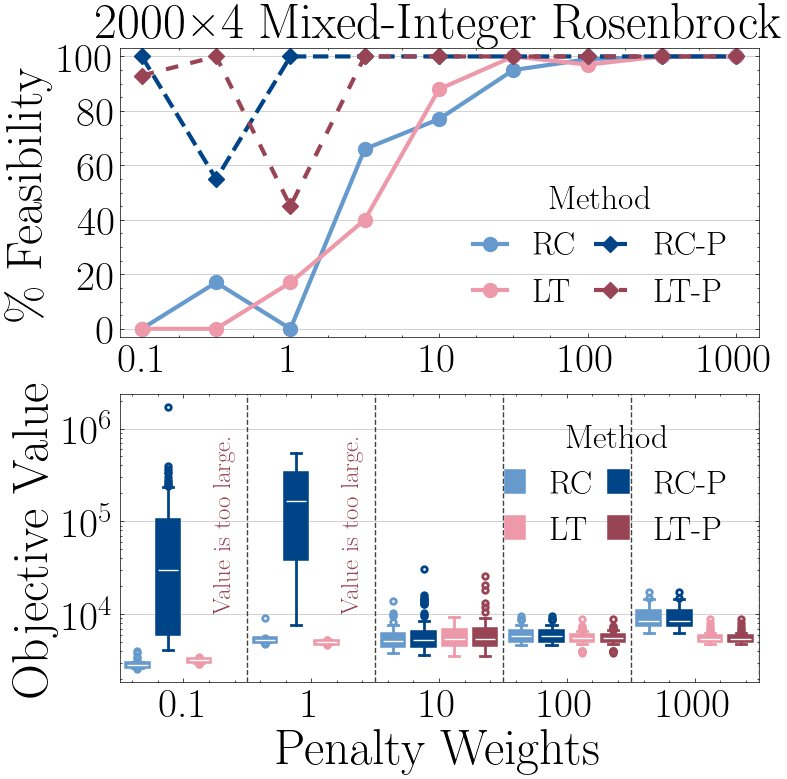

In [5]:
plot(problem="rb", size=1000)